In [ ]:
import os
import pandas as pd

data_dir = r"C:\Users\aksha\OneDrive\Desktop\mars\dataset"

emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

data = []

for file in os.listdir(data_dir):
    if file.endswith(".mp4") or file.endswith(".wav"):
        parts = file[:-4].split("-")
        if len(parts) == 7:
            modality, vocal, emotion, intensity, statement, repetition, actor = parts
            gender = "male" if int(actor) % 2 != 0 else "female"
            emotion_label = emotion_map.get(emotion)
            if emotion_label:
                data.append({
                    "filename": file,
                    "filepath": os.path.join(data_dir, file),
                    "emotion": emotion_label,
                    "gender": gender,
                    "actor_id": int(actor)
                })

df = pd.DataFrame(data)
print(df.head())


                   filename  \
0  03-01-01-01-01-01-01.wav   
1  03-01-01-01-01-01-02.wav   
2  03-01-01-01-01-01-03.wav   
3  03-01-01-01-01-01-04.wav   
4  03-01-01-01-01-01-05.wav   

                                            filepath  emotion  gender  \
0  C:\Users\aksha\OneDrive\Desktop\mars\dataset\0...  neutral    male   
1  C:\Users\aksha\OneDrive\Desktop\mars\dataset\0...  neutral  female   
2  C:\Users\aksha\OneDrive\Desktop\mars\dataset\0...  neutral    male   
3  C:\Users\aksha\OneDrive\Desktop\mars\dataset\0...  neutral  female   
4  C:\Users\aksha\OneDrive\Desktop\mars\dataset\0...  neutral    male   

   actor_id  
0         1  
1         2  
2         3  
3         4  
4         5  


In [6]:
df.columns

Index(['filename', 'filepath', 'emotion', 'gender', 'actor_id'], dtype='object')

In [2]:
import librosa
import numpy as np

def extract_features(filepath):
    y, sr = librosa.load(filepath, sr=16000)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return np.mean(mfccs.T, axis=0)
    
df['features'] = df['filepath'].apply(extract_features)




In [2]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df, 
    test_size=0.2, 
    stratify=df['emotion'], 
    random_state=42
)


In [5]:
train_df.columns

Index(['filename', 'filepath', 'emotion', 'gender', 'actor_id', 'features'], dtype='object')

In [34]:
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, BatchNormalization, 
                                    Dense, Dropout, Input, GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import warnings
import hashlib
import pickle
from datetime import datetime



In [ ]:
warnings.filterwarnings('ignore')

TARGET_TIME = 94  
TARGET_ROWS = 32  
TARGET_CHANNELS = 2
FEATURE_VERSION = "v2.0"  
MODEL_VERSION = "v5"  
MODEL_DESCRIPTION = "baseline"  
EXPERIMENT_NAME = f"emotion_model_{MODEL_VERSION}_{MODEL_DESCRIPTION}"


In [ ]:
def ensure_shape(array, target_shape):
    
    if array.size == 0:
        return np.zeros(target_shape)
    
    current_shape = array.shape
    
    if len(current_shape) >= 2:
        if current_shape[1] > target_shape[1]:
            array = array[:, :target_shape[1]]
        elif current_shape[1] < target_shape[1]:
            pad_width = [(0, 0), (0, target_shape[1] - current_shape[1])]
            array = np.pad(array, pad_width, mode='constant', constant_values=0)
    
    if current_shape[0] > target_shape[0]:
        array = array[:target_shape[0], :]
    elif current_shape[0] < target_shape[0]:
        pad_width = [(0, target_shape[0] - current_shape[0]), (0, 0)]
        array = np.pad(array, pad_width, mode='constant', constant_values=0)
    
    return array




In [ ]:
def normalize_features(features):
    if features.size == 0:
        return features
    
    mean = np.mean(features)
    std = np.std(features)
    
    if std == 0 or np.isnan(std):
        return features - mean
    
    return (features - mean) / std



In [ ]:
def create_enhanced_features(filepath, target_sr=16000, duration=3.0):
    try:
        if not os.path.exists(filepath):
            return np.zeros((TARGET_ROWS, TARGET_TIME, TARGET_CHANNELS))
        
        try:
            y, sr = librosa.load(filepath, sr=target_sr, duration=duration)
        except Exception:
            return np.zeros((TARGET_ROWS, TARGET_TIME, TARGET_CHANNELS))
        
        if len(y) == 0:
            return np.zeros((TARGET_ROWS, TARGET_TIME, TARGET_CHANNELS))
        
        target_length = int(duration * sr)
        if len(y) > target_length:
            y = y[:target_length]
        else:
            y = np.pad(y, (0, max(0, target_length - len(y))), mode='constant')
        
        n_fft = 1024
        hop_length = 512
        n_mels = 32
        
        try:
            mel = librosa.feature.melspectrogram(
                y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
            channel1 = librosa.power_to_db(mel, ref=np.max)
            channel1 = ensure_shape(channel1, (TARGET_ROWS, TARGET_TIME))
            channel1 = normalize_features(channel1)
        except Exception:
            channel1 = np.zeros((TARGET_ROWS, TARGET_TIME))
        
        try:
            mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, 
                                       n_fft=n_fft, hop_length=hop_length)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=hop_length)
            contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=hop_length)
            
            channel2 = np.vstack([mfcc, chroma, contrast])
            channel2 = ensure_shape(channel2, (TARGET_ROWS, TARGET_TIME))
            channel2 = normalize_features(channel2)
        except Exception:
            channel2 = np.zeros((TARGET_ROWS, TARGET_TIME))
        
        features = np.stack([channel1, channel2], axis=-1)
        
        return features
    
    except Exception:
        return np.zeros((TARGET_ROWS, TARGET_TIME, TARGET_CHANNELS))




In [ ]:
def targeted_augmentation(features, labels):
    if len(features) == 0:
        return features, labels
        
    # Calculate class distribution
    unique, counts = np.unique(labels, return_counts=True)
    median_count = np.median(counts)
    
    print("Applying targeted augmentation:")
    print(f"Class distribution: {dict(zip(unique, counts))}")
    print(f"Median count: {median_count}")
    
    total_augmented = sum(max(0, int(median_count - count)) for count in counts)
    if total_augmented == 0:
        return features, labels
        
    augmented_features = np.zeros((total_augmented, *features.shape[1:]), dtype=features.dtype)
    augmented_labels = np.zeros(total_augmented, dtype=labels.dtype)
    
    current_idx = 0
    
    for class_label, count in zip(unique, counts):
        augment_count = max(0, int(median_count - count))
        if augment_count == 0:
            continue
            
        class_indices = np.where(labels == class_label)[0]
        
        for i in range(augment_count):
            sample_idx = np.random.choice(class_indices)
            feature = features[sample_idx]
            
            aug_type = np.random.choice(['noise', 'time_mask', 'freq_mask', 'gain'])
            
            if aug_type == 'noise':
                new_feature = feature + np.random.normal(0, 0.02, feature.shape)
            elif aug_type == 'time_mask':
                new_feature = np.copy(feature)
                mask_length = np.random.randint(5, 15)
                start = np.random.randint(0, max(1, feature.shape[1] - mask_length))
                new_feature[:, start:start+mask_length, :] = 0
            elif aug_type == 'freq_mask':
                new_feature = np.copy(feature)
                mask_length = np.random.randint(3, 8)
                start = np.random.randint(0, max(1, feature.shape[0] - mask_length))
                new_feature[start:start+mask_length, :, :] = 0
            else:  
                gain = np.random.uniform(0.8, 1.2)
                new_feature = feature * gain
            
            augmented_features[current_idx] = new_feature
            augmented_labels[current_idx] = class_label
            current_idx += 1
    
    all_features = np.concatenate([features, augmented_features], axis=0)
    all_labels = np.concatenate([labels, augmented_labels], axis=0)
    
    return all_features, all_labels


In [ ]:
def build_optimized_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)
    
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def get_class_weights(y):
    unique, counts = np.unique(y, return_counts=True)
    median = np.median(counts)
    weights = {}
    
    print("\nClass distribution:")
    for i, cls in enumerate(unique):
        weight = median / counts[i]
        if counts[i] < median * 0.5:
            weight = weight ** 1.5
        weights[i] = weight
        print(f"Class {cls}: count={counts[i]}, weight={weight:.2f}")
        
    return weights




In [ ]:
def get_enhanced_callbacks(model_name):
    return [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True,
            mode='max',
            verbose=1,
            min_delta=0.001
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1,
            cooldown=2
        ),
        ModelCheckpoint(
            f'{model_name}_best.keras',
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
    ]



In [ ]:
def prepare_enhanced_features(df, augment=False, cache_dir='feature_cache'):
    filepaths = sorted(df['filepath'].tolist())
    key_str = f"{FEATURE_VERSION}_{TARGET_ROWS}_{TARGET_TIME}_{TARGET_CHANNELS}_{len(filepaths)}"
    base_cache_key = hashlib.md5(key_str.encode('utf-8')).hexdigest()
    cache_file = os.path.join(cache_dir, base_cache_key + ".npz")
    
    os.makedirs(cache_dir, exist_ok=True)
    
    if os.path.exists(cache_file):
        print(f"Loading features from cache: {cache_file}")
        with np.load(cache_file) as data:
            base_features = data['features']
            base_labels = data['labels']
    else:
        base_features = []
        base_labels = []
        print(f"Processing {len(df)} files...")
        
        batch_size = 100
        for i in range(0, len(df), batch_size):
            batch_df = df.iloc[i:i+batch_size]
            batch_features = []
            batch_labels = []
            
            for _, row in batch_df.iterrows():
                feature = create_enhanced_features(row['filepath'])
                if feature.shape == (TARGET_ROWS, TARGET_TIME, TARGET_CHANNELS):
                    batch_features.append(feature)
                    batch_labels.append(row['emotion'])
            
            if batch_features:
                base_features.extend(batch_features)
                base_labels.extend(batch_labels)
        
        base_features = np.array(base_features)
        base_labels = np.array(base_labels)
        
        np.savez(cache_file, features=base_features, labels=base_labels)
        print(f"Saved features to cache: {cache_file}")
    
    print(f"Base features: {len(base_features)} samples")
    
    if augment:
        print("Applying targeted augmentation...")
        features, labels = targeted_augmentation(base_features, base_labels)
        print(f"After augmentation: {features.shape[0]} samples")
    else:
        features, labels = base_features, base_labels
    
    return features, labels



In [ ]:
def create_sample_dataset(dataset_path):
    emotion_mapping = {
        '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
        '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
    }
    
    audio_files = glob.glob(os.path.join(dataset_path, "*.wav"))
    
    if not audio_files:
        print(f"No audio files found in {dataset_path}")
        return None
    
    filepaths = []
    emotions = []
    
    for file in audio_files:
        try:
            filename = os.path.basename(file)
            parts = filename.split('-')
            if len(parts) >= 3:
                emotion_code = parts[2]
                if emotion_code in emotion_mapping:
                    filepaths.append(file)
                    emotions.append(emotion_mapping[emotion_code])
        except:
            continue
    
    if not filepaths:
        print("Using generic labels")
        emotions = [f"emotion_{i%4}" for i in range(len(audio_files))]
        filepaths = audio_files
    
    return pd.DataFrame({
        'filepath': filepaths,
        'emotion': emotions
    })



In [ ]:

def predict_emotion(model_path, audio_file, label_encoder_path):
    model = tf.keras.models.load_model(model_path)
    
    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)
    
    features = create_enhanced_features(audio_file)
    features = np.expand_dims(features, axis=0)
    
    predictions = model.predict(features, verbose=0)
    pred_class = np.argmax(predictions[0])
    confidence = predictions[0][pred_class]
    
    emotion = label_encoder.inverse_transform([pred_class])[0]
    return emotion, confidence



In [ ]:
def save_training_results(history, model_name, train_acc, val_acc, classification_rep):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"{model_name}_results_{timestamp}.txt"
    
    with open(results_file, 'w') as f:
        f.write(f"Training Results for {model_name}\n")
        f.write("="*50 + "\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Model Version: {MODEL_VERSION}\n")
        f.write(f"Model Description: {MODEL_DESCRIPTION}\n")
        f.write(f"Training Accuracy: {train_acc:.4f}\n")
        f.write(f"Validation Accuracy: {val_acc:.4f}\n")
        f.write("\nClassification Report:\n")
        f.write(classification_rep)
        f.write("\n" + "="*50 + "\n")
    
    print(f"Results saved to: {results_file}")


In [ ]:
def extract_classwise_accuracy(model_path, label_encoder_path, dataset_path):
    model = tf.keras.models.load_model(model_path)
    with open(label_encoder_path, 'rb') as f:
        le = pickle.load(f)
    
    df = create_sample_dataset(dataset_path)
    _, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion'])
    
    X_val, y_val_labels = prepare_enhanced_features(val_df, augment=False)
    y_val = le.transform(y_val_labels)
    y_val_cat = to_categorical(y_val)
    
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    class_accuracy = {}
    cm = confusion_matrix(y_val, y_pred_classes)
    for i, class_name in enumerate(le.classes_):
        correct = cm[i, i]
        total = np.sum(cm[i, :])
        class_accuracy[class_name] = correct / total if total > 0 else 0.0
    
    print("\nCLASS-WISE VALIDATION ACCURACY:")
    print("-" * 50)
    for class_name, acc in class_accuracy.items():
        status = "PASS" if acc >= 0.75 else "FAIL"
        print(f"{class_name.upper()}: {acc:.4f} ({status})")
    print("-" * 50)
    
    overall_acc = np.mean(list(class_accuracy.values()))
    report = classification_report(y_val, y_pred_classes, target_names=le.classes_, output_dict=True)
    f1_weighted = report['weighted avg']['f1-score']
    
    print(f"\nOVERALL ACCURACY: {overall_acc:.4f} ({'PASS' if overall_acc >= 0.8 else 'FAIL'})")
    print(f"WEIGHTED F1-SCORE: {f1_weighted:.4f} ({'PASS' if f1_weighted >= 0.8 else 'FAIL'})")
    print(f"ALL CLASSES >75%: {'PASS' if all(acc >= 0.75 for acc in class_accuracy.values()) else 'FAIL'}")
    
    return class_accuracy


Starting training for: emotion_model_v5_baseline
Model Version: v5
Model Description: baseline
Dataset created with 2452 files
Emotions: ['neutral' 'calm' 'happy' 'sad' 'angry' 'fearful' 'disgust' 'surprised']
Distribution:
emotion
calm         376
happy        376
sad          376
angry        376
fearful      376
disgust      192
surprised    192
neutral      188
Name: count, dtype: int64

Training samples: 1961
Validation samples: 491

=== Preparing training features ===
Loading features from cache: feature_cache\80e8c44303b12e22535a26686ea1040e.npz
Base features: 1961 samples
Applying targeted augmentation...
Applying targeted augmentation:
Class distribution: {'angry': 301, 'calm': 301, 'disgust': 153, 'fearful': 301, 'happy': 301, 'neutral': 150, 'sad': 301, 'surprised': 153}
Median count: 301.0
After augmentation: 2408 samples

=== Preparing validation features ===
Loading features from cache: feature_cache\0da9b6cfbe3c1e9544b9093351b3ab62.npz
Base features: 491 samples

Dataset

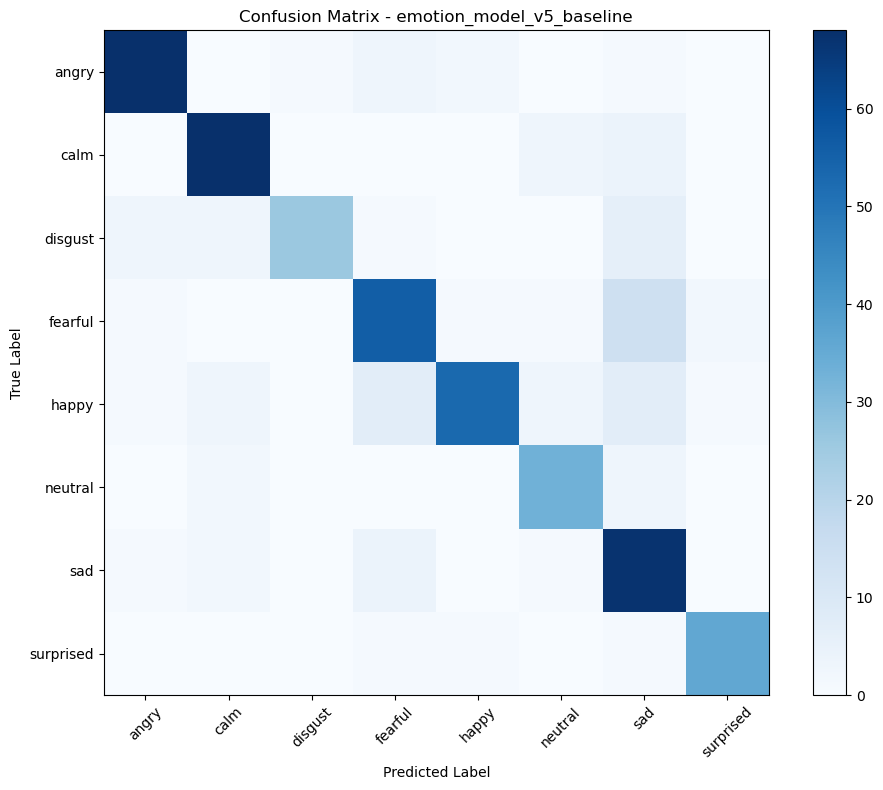

Results saved to: emotion_model_v5_baseline_results_20250620_113435.txt

Files saved:
  - emotion_model_v5_baseline_best.keras (best model during training)
  - emotion_model_v5_baseline_final.keras (final model)
  - emotion_model_v5_baseline_label_encoder.pkl (label encoder)
  - emotion_model_v5_baseline_confusion_matrix.png (confusion matrix)
  - emotion_model_v5_baseline_results_*.txt (training results)


In [ ]:



def main():
    """Main execution function"""
    print(f"Starting training for: {EXPERIMENT_NAME}")
    print(f"Model Version: {MODEL_VERSION}")
    print(f"Model Description: {MODEL_DESCRIPTION}")
    print("="*50)
    
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)
    
    dataset_path = r"C:\Users\aksha\OneDrive\Desktop\mars\dataset"
    
    df = create_sample_dataset(dataset_path)
    if df is None:
        print("Failed to create dataset. Please check your dataset path.")
        return
    
    print(f"Dataset created with {len(df)} files")
    print(f"Emotions: {df['emotion'].unique()}")
    print(f"Distribution:\n{df['emotion'].value_counts()}")
    
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['emotion'])
    
    print(f"\nTraining samples: {len(train_df)}")
    print(f"Validation samples: {len(val_df)}")
    
    try:
        print("\n=== Preparing training features ===")
        X_train, y_train_labels = prepare_enhanced_features(train_df, augment=True)
        
        print("\n=== Preparing validation features ===")
        X_val, y_val_labels = prepare_enhanced_features(val_df, augment=False)
        
        if len(X_train) == 0 or len(X_val) == 0:
            print("No features extracted. Exiting.")
            return
        
        le = LabelEncoder()
        y_train = le.fit_transform(y_train_labels)
        y_val = le.transform(y_val_labels)
        
        y_train_cat = to_categorical(y_train)
        y_val_cat = to_categorical(y_val)
        
        print("\nDataset summary:")
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Classes: {le.classes_}")
        print(f"Input shape: {X_train.shape[1:]}")
        
        model = build_optimized_model(X_train.shape[1:], len(le.classes_))
        
        class_weight_dict = get_class_weights(y_train)
        
        model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        
        print(f"\nModel parameters: {model.count_params():,}")
        
        print(f"\n=== Training model: {EXPERIMENT_NAME} ===")
        history = model.fit(
            X_train, y_train_cat,
            validation_data=(X_val, y_val_cat),
            epochs=50,
            batch_size=32,
            callbacks=get_enhanced_callbacks(EXPERIMENT_NAME),
            class_weight=class_weight_dict,
            verbose=1
        )
        
        model = tf.keras.models.load_model(f'{EXPERIMENT_NAME}_best.keras')
        
        train_loss, train_acc = model.evaluate(X_train, y_train_cat, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val_cat, verbose=0)
        
        print("\n" + "="*50)
        print(f"MODEL RESULTS FOR {EXPERIMENT_NAME}:")
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Validation Accuracy: {val_acc:.4f}")
        print("="*50 + "\n")
        
        y_pred = model.predict(X_val)
        y_pred_classes = np.argmax(y_pred, axis=1)
        
        print("CLASSIFICATION REPORT:")
        classification_rep = classification_report(y_val, y_pred_classes, target_names=le.classes_)
        print(classification_rep)
        
        cm = confusion_matrix(y_val, y_pred_classes)
        plt.figure(figsize=(10, 8))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - {EXPERIMENT_NAME}')
        plt.colorbar()
        tick_marks = np.arange(len(le.classes_))
        plt.xticks(tick_marks, le.classes_, rotation=45)
        plt.yticks(tick_marks, le.classes_)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{EXPERIMENT_NAME}_confusion_matrix.png')
        plt.show()
        
        model.save(f'{EXPERIMENT_NAME}_final.keras')
        with open(f'{EXPERIMENT_NAME}_label_encoder.pkl', 'wb') as f:
            pickle.dump(le, f)
        
        save_training_results(history, EXPERIMENT_NAME, train_acc, val_acc, classification_rep)
        
        print(f"\nFiles saved:")
        print(f"  - {EXPERIMENT_NAME}_best.keras (best model during training)")
        print(f"  - {EXPERIMENT_NAME}_final.keras (final model)")
        print(f"  - {EXPERIMENT_NAME}_label_encoder.pkl (label encoder)")
        print(f"  - {EXPERIMENT_NAME}_confusion_matrix.png (confusion matrix)")
        print(f"  - {EXPERIMENT_NAME}_results_*.txt (training results)")
        
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()